Integrantes:
- Nicolás Dominutti
- Carlos Suárez Gurruchaga
- Hernán Telechea

# Práctica 1: Reconocimiento de dígitos manuscritos con extracción manual de características

El nuevo banco "First bank of Wiki" desea implementar un sistema de reconocimiento automático de cheques como el siguiente:

![texto alternativo](https://upload.wikimedia.org/wikipedia/commons/b/b9/CanadianChequeSample.png)


Actualmente, el banco cuenta con un sistema capaz de aislar los dígitos y convertirlos en imágenes de 8 x 8, pero no de reconocer de qué dígito se trata. Por esa razón, nos ha solicitado realizar un módulo capaz de reconocer dígitos manuscritos dada una imagen de 8 x 8 pixeles:


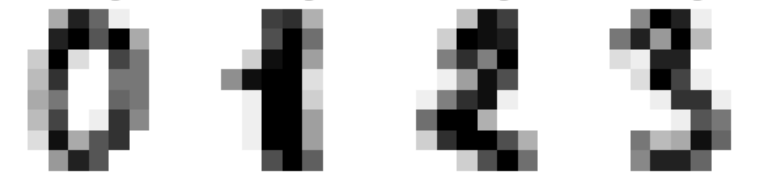



# Cargando los datos

Primero vamos a cargar el dataset y visualizar algunos dígitos.

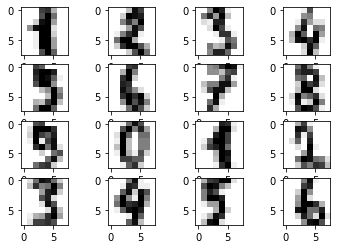

In [ ]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.linear_model import Perceptron
from typing import Union
import seaborn as sns
from sklearn.decomposition import PCA

digits = load_digits()

for i in range(1,17):
    plt.subplot(4,4,i)
    plt.imshow(digits.images[i,:,:], cmap=plt.get_cmap('gray_r'))


# Binarizando el problema

Para comenzar con un problema más simple, sólo trabajaremos en el escenario de clasificación binaria para dígitos 0 y 1. Para eso, primero filtramos los datos y luego los particionamos en training y test folds.

In [ ]:
# Cargo los dígitos
#X, y = load_digits(return_X_y=True)
X, y = digits.images, digits.target

# Filtro los que sean 0 o 1
indices = np.array(range(X.shape[0]))
bin_indices = indices[(y==0) | (y == 1)]

X_bin = X[bin_indices,:,:]
y_bin = y[bin_indices]

# Creo los splits para training y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_bin_train, X_bin_test, y_bin_train, y_bin_test = train_test_split(X_bin, y_bin, test_size=0.33, random_state=42)

print("Total de datos para clasificación entre 10 dígitos: " + str(y.shape[0]))
print("Total de datos para clasificación binaria: " + str(y_bin.shape[0]))
print("Total de 1s para clasificación binaria: " + str(y_bin_test.sum()))
print("Total de 0s para clasificación binaria: " + str(y_bin_test.shape[0] - y_bin_test.sum()))


Total de datos para clasificación entre 10 dígitos: 1797
Total de datos para clasificación binaria: 360
Total de 1s para clasificación binaria: 60
Total de 0s para clasificación binaria: 59


Visualizamos ahora los dígitos del problema binario

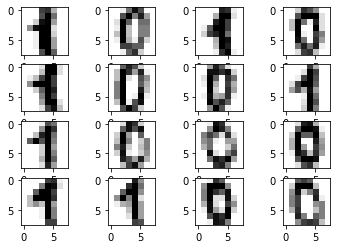

In [ ]:
for i in range(1,17):
    plt.subplot(4,4,i)
    plt.imshow(X_bin[i,:,:], cmap=plt.get_cmap('gray_r'))

# Entrenando un perceptrón simple con extracción manual de características para clasificación binaria

Ahora procederemos a entrenar un perceptrón usando la biblioteca Scikit Learn. Esta biblioteca de aprendizaje automático implementa muchísimos modelos listos para usar. En este caso, usaremos el perceptrón simple `sklearn.linear_model.Perceptron`

Pero antes de definir el perceptrón, vamos a definir el método de extracción de características que transformará una imagen (`np.array`) de 8 x 8 en un vector unidimensional de 2 componentes. Para ello, podemos probar con dos estrategias diferentes (si se les ocurre alguna otra, adelante!):

* **Estrategia 1:** vamos a considerar la feature 0 como la media de intensidades de la parte superior del dígito (filas 0 a 3) y y la feature 1 como la media de la parte inferior (filas 4 a 7) tal como indica la imagen:

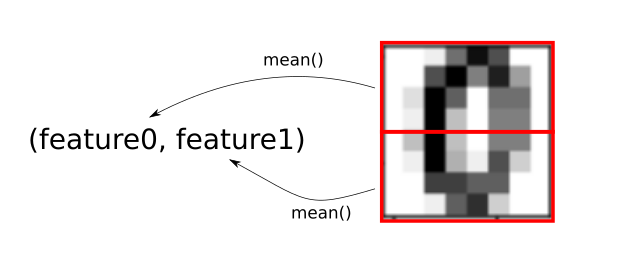

* **Estrategia 2:** Como alternativa, vamos a considerar la feature 0 como la media de toda la imagen, y la feature 1 como el desvío estandar:

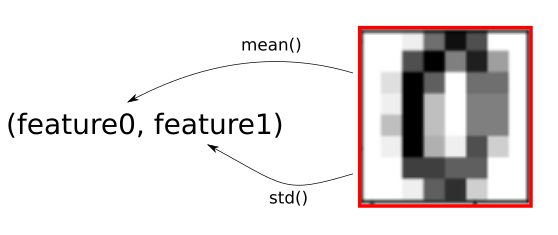


In [ ]:
def extract_features_mean_std(x):
  x_out = np.zeros(shape=(1,2))
  x_out[0,0] = np.mean(x)
  x_out[0,1] = np.std(x)

  return x_out

def extract_features_mean_top_bottom(x):
  x_out = np.zeros(shape=(1,2))
  x_out[0,0] = np.mean(x[:4,:])
  x_out[0,1] = np.mean(x[4:,:])

  return x_out

def preprocess_features_mean_std(X):
  X_pp = np.zeros(shape=(X.shape[0], 2))

  for i in range(X.shape[0]):
    X_pp[i,:] = extract_features_mean_std(X[i,:,:])

  return X_pp
  
def preprocess_features_mean_top_bottom(X):
  X_pp = np.zeros(shape=(X.shape[0], 2))

  for i in range(X.shape[0]):
    X_pp[i,:] = extract_features_mean_top_bottom(X[i,:,:])

  return X_pp

In [ ]:
class Lab():
  """Lab de experimentación de un Perceptron simple aplicado al problema
      de clasificación de números escritos a mano.

      Args:
          exp_name (str): nombre que se le quiere dar al experimento
          exp_desc (str): descripción del experimento
      """
  def __init__(self,
               exp_name:str,
               exp_desc:str):
    self.exp_name = exp_name
    self.exp_desc = exp_desc
    self.process_flag = ""

  def experiment(self, 
                feat_extract_pipeline:object,
                X_train:np.array,
                X_test:np.array,
                y_train:np.array,
                y_test:np.array
    ) -> Union[sklearn.linear_model.Perceptron, int]:
    """Performa el experimento indicado

      Args:
          feat_extract_pipeline (object): pipeline de extracción de features de las imágenes
          X_train (np.array): set de datos de train
          X_test (np.array): set de datos de test
          y_train (np.array): labels de los casos de train
          y_test (np.array): labels de los casos de test

      Returns:
          Union[sklearn.linear_model.Perceptron, int]: perceptrón simple entrenado,
          score del experimento sobre test
      """
    print('*'*30+f' Experimento {self.exp_name}: {self.exp_desc} '+'*'*30)
    clasificador = Perceptron()

    # Transformamos las features de los datos para el problema binario
    X_bin_train_features = feat_extract_pipeline(X_train)
    X_bin_test_features = feat_extract_pipeline(X_test)
    self.X_bin_test_features = X_bin_test_features
    self.dimension = X_bin_train_features.shape[1]
    # Entrenamos el clasificador
    clasificador.fit(X_bin_train_features, y_train)
    self.clasificador = clasificador

    # Imprimir la accuracy en los datos de test.
    self.score = clasificador.score(
                                  X_bin_test_features, y_test)
    print("Accuracy en test: " + str(self.score))
    
    self.prediccion = clasificador.predict(X_bin_test_features)
    # Imprimir las predicciones realizadas para los datos de test
    print("Predictions: " + str(self.prediccion))

    return clasificador, clasificador.score(X_bin_test_features, y_test)

  def _check_dimensionality(self) -> None:
    """Checkea dimensionalidad, si la misma es superior a 2, aplica PCA.
    """
    if self.X_bin_test_features.shape[1]>2:
      print('> Aplicando PCA...')
      pca = PCA(n_components=2)
      self.X_bin_test_features = pca.fit_transform(self.X_bin_test_features)
      self.process_flag = 'Se aplicó PCA'

  def plot(self, axes) -> None:
    """Genera plot del experimento

      Args:
          axes (:object:): axes de matplotlib sobre las cuales plotear
    """
    self._check_dimensionality()
    assert self.clasificador, 'Debe correr el experimento antes de plotear'
    sns.scatterplot(
      x=self.X_bin_test_features[:,0],
      y=self.X_bin_test_features[:,1],
      hue=y_bin_test,
      ax=axes
    )
    axes.set_title(f'Espacio de features con clasificación\n\
    desc: {self.exp_desc}\n\
    score:{np.round(self.score,3)}\n\
    dimension: {self.dimension}\n\
    {self.process_flag}')

  def plot2(self, axes) -> None:
    self._check_dimensionality()
    assert self.clasificador, 'Debe correr el experimento antes de plotear'
    sns.scatterplot(
      x=self.X_bin_test_features[:,0],
      y=self.X_bin_test_features[:,1],
      hue=y_test,
      ax=axes
    )
    axes.set_title(f'Espacio de features con clasificación\n\
    desc: {self.exp_desc}\n\
    score:{np.round(self.score,3)}\n\
    dimension: {self.dimension}\n\
    {self.process_flag}')

Ahora implementamos el perceptrón usando la clase `sklearn.linear_model.Perceptron` y lo entrenamos usando las features elegidas (probar con ambas features y ver cuál da mejor accuracy).

# Estrategia A

Media de la parte superior y media de la parte inferior

In [ ]:
#Experimento con 0 y 1
labA_0_1 = Lab( 'A', 'media top y media bottom | Imágenes 0 y 1')
clasificador, score_exp1_A = labA_0_1.experiment(
                                        preprocess_features_mean_top_bottom,
                                        X_bin_train,
                                        X_bin_test,
                                        y_bin_train,
                                        y_bin_test
                                    )

****************************** Experimento A: media top y media bottom | Imágenes 0 y 1 ******************************
Accuracy en test: 0.5378151260504201
Predictions: [0 0 1 1 1 1 1 0 1 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 1 0
 0 0 0 1 0 1 1 1 1 0 1 0 0 1 1 0 0 1 0 1 1 1 1 0 1 0 0 0 1 0 0 1 1 0 0 1 0
 1 1 1 1 1 1 1 1 0 1 0 1 0 0 0 0 0 1 1 1 1 1 0 0 1 0 0 1 0 0 0 0 0 1 0 1 1
 0 1 1 1 0 1 1 1]


In [ ]:
#Experimento con todos los dígitos
labA_full = Lab( 'A', 'media top y media bottom | Imágenes full')
clasificador, score_exp2_A = labA_full.experiment(
                                        preprocess_features_mean_top_bottom,
                                        X_train,
                                        X_test,
                                        y_train,
                                        y_test
                                    )

****************************** Experimento A: media top y media bottom | Imágenes full ******************************
Accuracy en test: 0.16666666666666666
Predictions: [4 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 4 8 8 8 8 6 8 8 6 8 6 8 4 4 8 8 8
 8 8 6 6 8 8 8 6 8 8 8 6 8 8 8 8 8 4 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 4 8 8 8 8 8 8 8 8 8 4 8 4 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 6 8 8 8 8 8 8 8 8 8 8 8 8 8 6 6 8 8 8 8 8 8 6 8 8 6 8
 8 8 8 8 8 8 6 8 8 8 8 8 8 8 8 8 8 8 8 6 8 8 8 8 4 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 6 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 6 8 8 6 8 8 8 8 8
 8 8 8 8 6 8 8 8 8 6 8 8 8 4 8 8 6 8 8 8 8 8 8 8 8 8 8 8 8 4 8 8 8 8 8 8 8
 8 6 8 8 8 8 8 8 8 4 8 8 8 8 6 8 8 6 8 8 8 6 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 4 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 6 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 6 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 6 8 8 8 8 8 8 8 8 8
 8 8 4 8 8 6 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 4 8 8 8 8 8 8 6 8 8 8 8 8
 8 8 8

# Estrategia B

Media full imagen y STD

In [ ]:
labB_0_1 = Lab( 'B', 'media full y std | Imágenes 0 y 1')
clasificador, score_exp1_B = labB_0_1.experiment(
                                        preprocess_features_mean_std,
                                        X_bin_train,
                                        X_bin_test,
                                        y_bin_train,
                                        y_bin_test
                                    )

****************************** Experimento B: media full y std | Imágenes 0 y 1 ******************************
Accuracy en test: 0.8319327731092437
Predictions: [1 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 1
 0 0 0 0 0 1 0 1 1 1 0 1 0 1 0 0 0 0 0 1 0 0 1 0 1 0 0 1 0 0 1 0 0 1 1 0 0
 0 0 0 1 0 1 0 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0
 1 1 1 0 0 1 0 0]


In [ ]:
#Experimento con todos los dígitos
labB_full = Lab( 'B', 'media top y media bottom | Imágenes full')
clasificador, score_exp2_B = labB_full.experiment(
                                        preprocess_features_mean_std,
                                        X_train,
                                        X_test,
                                        y_train,
                                        y_test
                                    )

****************************** Experimento B: media top y media bottom | Imágenes full ******************************
Accuracy en test: 0.13973063973063973
Predictions: [5 8 5 5 5 5 5 5 5 5 5 5 8 8 5 5 8 8 8 8 5 5 8 5 5 5 5 5 5 8 5 8 5 5 5 8 5
 5 5 5 5 5 5 5 5 8 5 8 5 5 8 8 5 8 5 8 5 8 5 5 0 8 8 5 5 8 8 5 8 5 8 5 8 5
 5 5 5 5 5 8 8 5 5 5 8 8 5 5 5 8 5 5 8 5 8 5 5 8 5 8 5 8 5 5 5 5 5 5 5 8 5
 5 5 5 5 5 5 5 8 8 8 5 5 5 5 5 5 5 5 8 8 5 5 5 8 5 5 5 5 8 8 5 5 5 8 5 5 5
 8 5 5 5 8 8 5 8 8 5 5 5 5 5 8 8 5 5 8 5 5 5 8 8 8 5 5 5 5 5 5 5 8 8 8 8 5
 5 5 5 5 8 8 5 5 5 8 5 8 8 5 8 5 8 8 5 8 8 5 8 5 8 8 5 8 5 5 5 5 8 5 5 8 8
 5 8 5 5 5 8 5 5 5 8 5 5 5 5 5 5 5 5 5 8 5 5 8 5 8 8 5 8 5 5 5 8 8 5 5 5 5
 8 5 8 8 5 5 5 5 8 5 8 8 5 5 5 5 5 5 8 5 5 5 5 5 5 8 8 5 8 8 5 5 5 5 5 8 5
 8 5 5 5 8 5 5 5 5 5 8 8 8 8 5 5 5 8 5 8 5 5 5 5 5 8 5 8 5 8 5 5 8 8 5 5 8
 5 8 5 5 8 8 5 5 5 5 8 5 8 5 8 8 5 5 8 5 8 5 5 5 8 8 8 5 8 8 5 5 8 8 8 8 5
 5 8 5 5 5 5 5 5 8 8 5 5 5 8 8 8 5 8 5 8 5 8 8 5 5 5 5 8 5 8 8 5 5 5 5 5 8
 8 5 5

# Estrategia C

Tomar kernels de 4x4 sin overlap (4 cuadrantes de la imagen) y tomar el valor máximo

In [ ]:
def extract_features_max_4x4(x):
  x_out = np.zeros(shape=(1,4))
  x_out[0,0] = np.max(x[:4,:4])
  x_out[0,1] = np.max(x[4:,:4])
  x_out[0,2] = np.max(x[:4,4:])
  x_out[0,3] = np.max(x[4:,4:])
  return x_out

def preprocess_features_max_4x4(X):
  X_pp = np.zeros(shape=(X.shape[0], 4))
  # print(X_pp)

  for i in range(X.shape[0]):
    X_pp[i,:] = extract_features_max_4x4(X[i,:,:])

  return X_pp

In [ ]:
labC_0_1 = Lab( 'C', 'max en kernel 4x4 sin overlap | Imágenes 0 y 1')
clasificador, score_exp1_C = labC_0_1.experiment(
                                        preprocess_features_max_4x4,
                                        X_bin_train,
                                        X_bin_test,
                                        y_bin_train,
                                        y_bin_test
                                    )

****************************** Experimento C: max en kernel 4x4 sin overlap | Imágenes 0 y 1 ******************************
Accuracy en test: 0.5714285714285714
Predictions: [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 1 0]


In [ ]:
#Experimento con todos los dígitos
labC_full = Lab( 'C', 'max en kernel 4x4 sin overlap | Imágenes full')
clasificador, score_exp2_C = labC_full.experiment(
                                        preprocess_features_max_4x4,
                                        X_train,
                                        X_test,
                                        y_train,
                                        y_test
                                    )

****************************** Experimento C: max en kernel 4x4 sin overlap | Imágenes full ******************************
Accuracy en test: 0.1734006734006734
Predictions: [5 7 5 5 7 5 7 7 7 7 7 7 7 5 5 7 7 7 5 7 5 7 5 7 7 6 7 7 6 7 5 7 5 5 7 7 5
 5 5 5 5 5 7 7 5 5 7 7 5 7 5 7 5 7 7 5 5 7 5 5 7 5 5 7 5 5 7 5 7 5 7 5 7 7
 7 7 7 5 5 7 5 5 7 7 7 5 5 5 5 5 5 5 7 7 5 5 7 7 5 5 7 7 5 5 5 7 7 5 5 7 7
 7 5 5 7 7 7 7 7 7 7 5 7 7 5 5 7 7 7 7 7 5 7 5 5 5 5 7 7 7 5 5 7 6 5 5 6 7
 5 7 5 5 5 5 6 7 5 7 7 5 7 7 7 7 7 7 7 5 5 7 7 7 5 7 5 5 5 7 7 7 7 7 5 5 7
 7 5 7 7 5 7 7 7 7 5 7 7 7 7 5 5 7 7 7 7 5 5 7 7 7 7 7 5 5 5 5 5 7 7 7 7 7
 7 7 7 5 5 7 7 7 7 5 7 1 5 5 7 7 7 7 7 7 5 7 7 5 7 7 5 7 7 5 5 7 7 5 5 5 5
 7 6 7 7 5 5 5 7 5 5 5 7 5 7 6 7 5 5 5 7 7 5 5 7 7 7 7 7 7 7 7 5 7 5 7 7 5
 7 7 5 7 7 7 5 7 7 5 7 5 7 7 5 7 7 5 5 7 7 5 5 5 5 7 7 5 7 5 6 5 7 5 7 7 7
 7 5 5 5 7 7 5 7 5 7 7 5 5 7 5 5 7 7 7 1 7 7 7 7 5 7 5 6 5 5 5 7 7 7 5 5 5
 5 5 5 7 7 5 7 5 5 7 5 5 7 7 5 5 5 5 7 7 7 7 7 7 5 7 5 7 5 7 7 5 7 7 7 7 5
 5

# Estrategia D

Mismo que C pero tomando la media de valores en cada kernel

In [ ]:
def extract_features_mean_4x4(x):
  x_out = np.zeros(shape=(1,4))
  x_out[0,0] = np.mean(x[:4,:4])
  x_out[0,1] = np.mean(x[4:,:4])
  x_out[0,2] = np.mean(x[:4,4:])
  x_out[0,3] = np.mean(x[4:,4:])
  return x_out

def preprocess_features_mean_4x4(X):
  X_pp = np.zeros(shape=(X.shape[0], 4))

  for i in range(X.shape[0]):
    X_pp[i,:] = extract_features_mean_4x4(X[i,:,:])

  return X_pp

In [ ]:
labD_0_1 = Lab( 'D', 'mean en kernel 4x4 sin overlap | Imágenes 0 y 1')
clasificador, score_exp1_D = labD_0_1.experiment(
                                        preprocess_features_mean_4x4,
                                        X_bin_train,
                                        X_bin_test,
                                        y_bin_train,
                                        y_bin_test
                                    )

****************************** Experimento D: mean en kernel 4x4 sin overlap | Imágenes 0 y 1 ******************************
Accuracy en test: 0.6386554621848739
Predictions: [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0
 0 0 0 1 0 1 0 0 0 1 1 1 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 1 0 1 1 0]


In [ ]:
#Experimento con todos los dígitos
labD_full = Lab( 'D', 'mean en kernel 4x4 sin overlap | Imágenes full')
clasificador, score_exp2_D = labD_full.experiment(
                                        preprocess_features_mean_4x4,
                                        X_train,
                                        X_test,
                                        y_train,
                                        y_test
                                    )

****************************** Experimento D: mean en kernel 4x4 sin overlap | Imágenes full ******************************
Accuracy en test: 0.4444444444444444
Predictions: [6 5 3 7 2 5 5 3 5 8 3 3 2 2 8 8 3 7 3 5 3 3 5 7 5 6 3 5 6 3 6 3 3 6 8 6 5
 8 7 6 6 3 2 3 6 3 3 5 6 5 5 8 3 5 6 8 3 2 2 3 2 8 5 5 6 5 7 5 7 3 3 3 5 2
 7 2 3 5 5 3 8 5 5 3 8 2 6 8 6 3 5 3 3 3 5 3 5 3 3 2 3 3 5 3 3 7 5 9 8 3 7
 7 2 6 3 3 7 7 2 7 8 6 3 3 3 7 2 7 5 8 7 5 7 5 5 6 6 3 3 5 8 3 3 6 3 3 6 3
 3 3 5 6 6 5 6 8 3 5 3 5 7 2 3 8 3 5 3 6 5 5 8 2 6 2 2 6 7 3 8 2 3 3 8 8 3
 7 3 5 6 5 5 5 2 5 3 2 3 8 2 8 5 5 5 7 8 3 8 8 2 5 8 8 3 6 7 2 6 8 5 5 8 7
 3 6 3 5 6 8 3 2 3 6 7 3 5 6 8 7 6 5 8 5 5 3 5 3 2 8 5 5 7 6 5 2 3 3 6 8 5
 3 6 8 3 7 7 2 2 8 6 5 8 5 3 6 2 3 3 2 2 3 6 5 3 7 3 2 5 3 5 7 5 3 3 7 8 5
 8 3 8 2 3 5 6 3 3 2 5 8 5 5 6 3 3 3 5 8 7 3 7 5 5 8 5 8 7 5 6 3 7 3 5 2 5
 8 5 5 7 3 8 6 2 6 6 8 7 3 2 3 5 3 7 7 3 3 7 3 3 7 3 5 6 2 8 3 2 5 8 8 4 3
 6 8 6 5 5 6 3 5 8 5 8 5 3 8 3 8 2 8 5 6 3 3 7 2 6 3 5 2 3 2 8 6 3 3 2 3 8
 

# Estrategia E

Tomamos kernels de 4x4 comenzando en el borde izquierdo y movemos cada uno en dirección al borde derecho de a 1 paso a la vez (habrá overlap en el sentido horizontal pero no en el vertical)

In [ ]:
def extract_features_window_mean_4x4(x):
  x_out = np.zeros(shape=(1,10))
  p = 0
  for i in range(4):
    left_border  = i
    right_border = i+4
    x_out[0,p] = np.mean(x[:4,left_border:right_border])
    x_out[0,p+1] = np.mean(x[4:,left_border:right_border])
    p=p+1
  return x_out

def preprocess_features_window_mean_4x4(X):
  X_pp = np.zeros(shape=(X.shape[0], 10))

  for i in range(X.shape[0]):
    X_pp[i,:] = extract_features_window_mean_4x4(X[i,:,:])

  return X_pp

In [ ]:
labE_0_1 = Lab( 'E', 'mean en kernel 4x4 con overlap horizontal | Imágenes 0 y 1')
clasificador, score_exp1_E = labE_0_1.experiment(
                                        preprocess_features_window_mean_4x4,
                                        X_bin_train,
                                        X_bin_test,
                                        y_bin_train,
                                        y_bin_test
                                    )

****************************** Experimento E: mean en kernel 4x4 con overlap horizontal | Imágenes 0 y 1 ******************************
Accuracy en test: 0.9243697478991597
Predictions: [1 0 0 1 0 0 0 1 0 0 0 1 1 1 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 1
 0 0 0 1 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 1 0 1 1 0 1 0 0 1 0 1 1 0 0 0 1 0 0
 0 0 0 1 0 1 0 0 0 1 1 1 0 0 1 0 1 0 0 0 1 1 0 0 1 0 0 0 1 0 0 1 1 0 1 1 0
 1 1 1 1 0 1 0 0]


In [ ]:
#Experimento con todos los dígitos
labE_full = Lab( 'E', 'mean en kernel 4x4 con overlap horizontal | Imágenes full')
clasificador, score_exp2_E = labE_full.experiment(
                                        preprocess_features_window_mean_4x4,
                                        X_train,
                                        X_test,
                                        y_train,
                                        y_test
                                    )

****************************** Experimento E: mean en kernel 4x4 con overlap horizontal | Imágenes full ******************************
Accuracy en test: 0.18518518518518517
Predictions: [8 8 8 9 8 6 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 6 8 8 6 8 8 8 6 8 8 8 9
 8 9 6 6 8 8 8 6 8 8 8 6 8 8 8 8 8 8 8 8 8 8 8 9 8 8 8 8 8 8 9 8 8 8 8 8 8
 8 9 8 8 9 8 8 8 8 8 8 8 6 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 9 8 8 8
 8 8 8 8 8 8 8 8 8 8 6 8 4 6 8 8 8 8 8 9 8 8 9 9 6 6 8 8 9 8 8 8 6 8 9 6 8
 8 8 8 8 6 8 6 8 8 8 8 9 8 8 8 8 8 8 8 6 8 9 8 8 8 8 8 8 9 8 8 8 8 9 8 9 8
 8 8 8 6 8 9 8 8 8 8 8 8 8 8 8 8 9 8 8 8 8 8 8 8 8 8 8 8 6 8 8 6 8 8 8 8 9
 8 8 8 9 6 8 8 8 8 6 8 8 8 6 8 8 6 9 8 8 5 8 8 8 8 8 9 9 8 8 8 8 8 8 8 8 8
 8 6 8 8 8 9 9 8 9 8 8 8 8 8 6 8 8 6 8 8 8 6 8 8 8 8 8 8 8 8 9 8 8 8 8 8 9
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 6 8 8 8 8 8 8 8 8 9 8 8 8 8 8 8 6 8 9 8 8 8 8
 8 8 8 9 8 8 8 9 6 8 8 9 8 8 8 8 8 8 8 9 8 9 8 8 8 8 8 6 8 8 8 8 8 8 8 8 8
 8 8 8 8 9 6 8 8 8 8 8 8 8 8 8 8 8 8 9 8 8 8 8 8 8 8 8 8 8 8 8 6

# Estrategia F

Tomamos kernels de 4x4 comenzando en el borde izquierdo y movemos cada uno en dirección al borde derecho de a 1 paso a la vez, al llegar al limite movemos un paso hacia abajo y repetimos (habrá overlap horizontal y vertical)

In [ ]:
def extract_features_full_window_mean_4x4(x):
  x_out = np.zeros(shape=(1,25))
  p = 0
  for m in range(4):
    for i in range(4):
      left_border   = i
      right_border  = i+4
      top_border    = m
      bottom_border = m+4
      x_out[0,p] = np.mean(x[m:m+4,left_border:right_border])
      p=p+1
  return x_out

def preprocess_features_full_window_mean_4x4(X):
  X_pp = np.zeros(shape=(X.shape[0], 25))

  for i in range(X.shape[0]):
    X_pp[i,:] = extract_features_full_window_mean_4x4(X[i,:,:])

  return X_pp

In [ ]:
labF_0_1 = Lab( 'F', 'mean en kernel 4x4 con overlap horizontal y vertical | Imágenes 0 y 1')
clasificador, score_exp1_F = labF_0_1.experiment(
                                        preprocess_features_full_window_mean_4x4,
                                        X_bin_train,
                                        X_bin_test,
                                        y_bin_train,
                                        y_bin_test
                                    )

****************************** Experimento F: mean en kernel 4x4 con overlap horizontal y vertical | Imágenes 0 y 1 ******************************
Accuracy en test: 0.9915966386554622
Predictions: [1 0 0 1 0 0 0 1 0 1 0 1 1 1 0 1 1 0 1 1 0 0 0 0 1 0 0 0 0 1 0 1 1 1 1 1 1
 0 0 0 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 1 0 1 1 0 1 0 0 1 0 1 1 0 0 1 1 0 0
 0 0 0 1 0 1 0 0 1 1 1 1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 0 0 1 0 0 1 1 0 1 1 0
 1 1 1 1 0 1 1 0]


In [ ]:
#Experimento con todos los dígitos
labF_full = Lab( 'F', 'mean en kernel 4x4 con overlap horizontal y vertical | Imágenes full')
clasificador, score_exp2_F = labF_full.experiment(
                                        preprocess_features_full_window_mean_4x4,
                                        X_train,
                                        X_test,
                                        y_train,
                                        y_test
                                    )

****************************** Experimento F: mean en kernel 4x4 con overlap horizontal y vertical | Imágenes full ******************************
Accuracy en test: 0.6818181818181818
Predictions: [6 9 3 8 2 5 5 3 5 2 1 8 8 0 4 2 3 7 8 8 4 3 9 8 5 6 3 5 6 3 6 9 3 6 4 6 9
 4 8 6 6 9 8 3 6 1 3 9 6 5 8 8 9 5 6 0 9 8 0 1 0 4 5 2 4 5 1 9 1 6 9 6 5 8
 1 0 4 5 8 9 9 8 2 3 8 0 6 4 6 9 1 1 1 3 9 2 9 8 6 4 1 3 5 3 1 8 5 1 8 1 7
 1 8 6 1 9 8 1 8 1 2 6 9 4 6 1 2 8 5 8 8 5 1 5 0 6 6 8 2 8 0 9 1 6 8 9 6 9
 0 1 5 6 6 9 6 4 1 9 3 1 8 2 9 8 6 5 1 6 5 8 0 8 4 2 1 6 8 1 2 2 3 9 8 0 1
 2 3 5 6 9 9 4 1 5 1 2 3 6 4 8 5 9 5 7 8 9 4 8 1 5 4 4 9 6 8 8 6 6 4 5 2 8
 1 6 4 5 6 0 3 2 1 6 1 9 9 5 4 1 6 8 1 5 5 1 6 8 8 8 8 1 7 6 2 2 1 3 6 8 1
 3 6 0 9 1 8 0 1 9 4 5 8 5 3 6 0 1 1 0 0 3 6 5 9 1 3 6 5 9 9 8 5 3 3 7 0 5
 8 3 4 0 1 6 6 4 3 4 5 0 6 2 8 9 1 4 1 8 8 0 8 5 6 8 1 8 1 0 6 8 8 1 5 1 8
 1 5 8 8 9 8 6 0 6 2 0 8 9 8 9 8 1 7 8 9 9 8 4 3 8 3 5 6 0 0 3 0 5 6 0 8 1
 8 8 4 5 8 6 3 1 8 8 1 2 3 6 9 8 8 6 0 6 3 3 8 1 6 4 5

# Estrategia G

Aplicamos la misma lógica anterior, pero con un kernel 2x2

In [ ]:
def extract_features_full_window_mean_2x2(x):
  x_out = np.zeros(shape=(1,50))
  p = 0
  for m in range(6):
    for i in range(6):
      left_border   = i
      right_border  = i+2
      top_border    = m
      bottom_border = m+2
      x_out[0,p] = np.mean(x[m:m+2,left_border:right_border])
      p=p+1
  return x_out

def preprocess_features_full_window_mean_2x2(X):
  X_pp = np.zeros(shape=(X.shape[0], 50))

  for i in range(X.shape[0]):
    X_pp[i,:] = extract_features_full_window_mean_2x2(X[i,:,:])

  return X_pp

In [ ]:
labG_0_1 = Lab( 'G', 'mean en kernel 2x2 con overlap horizontal y vertical | Imágenes 0 y 1')
clasificador, score_exp1_G = labG_0_1.experiment(
                                        preprocess_features_full_window_mean_2x2,
                                        X_bin_train,
                                        X_bin_test,
                                        y_bin_train,
                                        y_bin_test
                                    )

****************************** Experimento G: mean en kernel 2x2 con overlap horizontal y vertical | Imágenes 0 y 1 ******************************
Accuracy en test: 0.9831932773109243
Predictions: [1 0 0 1 0 0 0 1 0 1 0 1 1 1 0 1 1 0 1 1 0 0 0 0 1 0 0 0 0 1 0 1 1 1 1 1 1
 0 0 0 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 1 0 1 1 0 1 0 0 1 0 1 1 0 0 1 1 0 0
 0 0 0 1 0 1 0 0 1 1 1 1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 0 0 1 0 0 1 1 0 1 1 0
 1 1 1 1 0 1 0 0]


In [ ]:
#Experimento con todos los dígitos
labG_full = Lab( 'G', 'mean en kernel 2x2 con overlap horizontal y vertical | Imágenes full')
clasificador, score_exp2_G = labG_full.experiment(
                                        preprocess_features_full_window_mean_2x2,
                                        X_train,
                                        X_test,
                                        y_train,
                                        y_test
                                    )

****************************** Experimento G: mean en kernel 2x2 con overlap horizontal y vertical | Imágenes full ******************************
Accuracy en test: 0.8956228956228957
Predictions: [6 9 3 9 2 5 5 2 5 2 2 9 4 0 4 2 3 7 9 8 4 3 9 7 5 6 3 5 6 3 4 9 3 4 4 6 9
 4 7 6 6 9 8 3 6 1 3 0 6 5 5 4 9 5 6 0 9 0 0 1 0 4 5 2 4 5 7 0 7 5 9 9 5 4
 7 0 4 5 9 9 9 0 2 3 8 0 6 4 4 9 1 2 8 3 9 2 9 0 4 4 4 3 5 3 1 3 5 9 4 2 7
 7 4 4 1 9 2 7 8 7 2 6 9 4 0 7 2 7 5 8 7 5 7 9 0 6 6 4 2 8 0 9 4 6 9 9 6 9
 0 3 5 6 6 0 6 4 3 9 3 9 7 2 9 0 4 5 3 6 5 9 9 8 4 2 8 3 7 3 2 2 3 9 8 0 3
 2 2 5 6 9 9 4 4 5 4 2 3 6 4 8 5 9 5 7 2 9 4 8 1 5 4 4 9 6 8 8 6 0 4 5 2 7
 4 6 4 5 6 0 3 2 3 6 7 9 9 1 4 7 6 5 8 5 5 1 4 2 8 8 9 9 7 6 2 2 2 3 4 8 8
 3 6 0 9 7 9 0 1 0 4 5 4 5 3 6 0 4 3 0 0 3 6 5 9 7 3 5 9 9 9 8 5 3 3 2 0 5
 8 3 4 0 2 4 6 4 3 4 5 0 5 2 5 3 4 4 2 8 7 0 6 5 8 8 2 8 7 0 6 4 8 8 5 1 8
 4 5 8 7 9 8 6 0 6 2 0 9 9 8 9 5 2 7 7 9 8 7 4 3 8 3 5 6 0 0 3 0 5 0 0 4 1
 2 8 6 5 9 6 3 4 8 8 4 2 3 8 9 8 8 5 0 6 3 3 7 1 6 4 5

# Estrategia H

Aplicamos la misma lógica anterior, pero agregamos un padding de 1 alrededor de las imágenes

In [ ]:
def pad(x):
  frist_pad  = np.concatenate([np.zeros((1,8)),x[:,:]])
  second_pad = np.concatenate([frist_pad,np.zeros((1,8))])
  third_pad = np.concatenate([np.zeros((10,1)), second_pad], axis=1)
  fourth_pad = np.concatenate([third_pad, np.zeros((10,1))], axis=1)
  
  return fourth_pad

def extract_features_window_full_pad_mean_4x4(x):
  x_out = np.zeros(shape=(1,36))
  p = 0
  for m in range(6):
    for i in range(6):
      left_border   = i
      right_border  = i+4
      top_border    = m
      bottom_border = m+4
      x_out[0,p] = np.mean(x[m:m+4,left_border:right_border])
      p=p+1
  return x_out

def preprocess_features_window_full_pad_mean_conv_4x4(X):
  X_pp = np.zeros(shape=(X.shape[0], 36))

  for i in range(X.shape[0]):
    x         = pad(X[i,:,:])
    X_pp[i,:] = extract_features_window_full_pad_mean_4x4(x)

  return X_pp

In [ ]:
labH_0_1 = Lab( 'H', 'mean en kernel 4x4 con overlap horizontal y vertical + pad | Imágenes 0 y 1')
clasificador, score_exp1_H = labH_0_1.experiment(
                                        preprocess_features_window_full_pad_mean_conv_4x4,
                                        X_bin_train,
                                        X_bin_test,
                                        y_bin_train,
                                        y_bin_test
                                    )

****************************** Experimento H: mean en kernel 4x4 con overlap horizontal y vertical + pad | Imágenes 0 y 1 ******************************
Accuracy en test: 1.0
Predictions: [1 0 0 1 0 0 0 1 0 1 0 1 1 1 0 1 1 0 1 1 0 0 0 0 1 0 0 0 0 1 0 1 1 1 1 1 1
 0 0 0 1 0 1 0 1 1 1 1 1 1 1 0 0 0 0 0 1 0 1 1 0 1 0 0 1 0 1 1 0 0 1 1 0 0
 0 0 0 1 0 1 0 0 1 1 1 1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 0 0 1 0 0 1 1 0 1 1 0
 1 1 1 1 0 1 1 0]


In [ ]:
#Experimento con todos los dígitos
labH_full = Lab( 'H', 'mean en kernel 4x4 con overlap horizontal y vertical + pad | Imágenes full')
clasificador, score_exp2_H = labH_full.experiment(
                                        preprocess_features_window_full_pad_mean_conv_4x4,
                                        X_train,
                                        X_test,
                                        y_train,
                                        y_test
                                    )

****************************** Experimento H: mean en kernel 4x4 con overlap horizontal y vertical + pad | Imágenes full ******************************
Accuracy en test: 0.8720538720538721
Predictions: [6 5 3 7 2 2 5 2 5 2 1 8 4 0 4 2 3 7 8 8 4 2 9 7 5 6 2 5 6 2 4 9 1 4 4 6 9
 4 7 6 6 9 1 3 6 1 3 0 6 5 5 1 9 5 6 0 9 0 0 1 0 4 5 2 4 5 7 0 7 5 9 5 5 4
 7 0 4 2 5 9 8 0 2 3 8 0 6 4 4 9 1 2 1 3 5 2 8 0 4 4 4 3 5 3 1 2 5 1 4 2 7
 7 4 4 1 9 2 7 8 7 2 6 9 4 2 7 2 7 5 8 7 5 7 5 0 6 6 4 2 8 0 9 4 6 8 9 6 9
 0 1 5 6 6 0 6 4 2 9 3 7 7 2 3 0 6 5 2 6 5 7 0 8 4 2 1 2 7 7 2 2 3 9 8 0 3
 2 2 5 6 9 9 4 1 2 4 2 3 6 4 8 5 8 5 7 1 9 4 8 1 5 4 4 9 6 1 8 6 0 4 2 2 7
 4 6 4 5 6 8 3 2 3 6 7 9 5 2 4 7 6 8 1 5 5 1 4 2 8 8 1 5 7 6 2 2 2 2 4 8 8
 3 6 0 8 7 7 0 1 0 4 5 8 5 3 6 0 4 1 0 0 2 6 5 9 7 3 5 5 9 9 8 5 3 3 2 0 5
 8 3 4 0 2 4 6 4 3 4 5 0 5 2 1 3 1 4 1 1 7 0 1 2 2 8 2 8 7 0 6 4 8 1 5 1 8
 4 5 8 7 9 8 6 0 6 2 0 7 8 1 9 5 2 7 7 9 7 7 4 3 8 3 5 6 0 0 3 0 5 6 0 4 1
 2 8 4 5 5 6 3 1 8 8 4 2 3 8 9 8 8 8 0 6 3 3 7 1

----

# Entregable:
* Deberán entregar el Colab completo con el código funcionando. Además, deberán incluir (en el mismo Colab) un pequeño informe donde muestren las visualizaciones de las features, y responder a las siguientes preguntas:

1. ¿Cuál fue la estrategia de extracción de características que mejor te funcionó? Visualizar las features generadas por los extractores implementados y utilizarlas para explicar por qué funcionó mejor esa estrategia. Si lo desean, pueden proponer sus propias features para mejorar la tasa de acierto del clasfiicador.

2. ¿Cuál sería la accuracy para un algoritmo que prediga aleatoriamente las clases en el caso del problema binario si los datos de test estuvieran balanceados? ¿Y en el caso del problema multiclase de 10 dígitos? 

3. El clasificador diseñado en cada caso (binario y multiclase), ¿Funcionó mejor que un clasificador aleatorio?



### **Informe**

**Ejercicio 1)**

Dentro del presente trabajo se probaron 8 estrategias distintas de *feature extraction*, las mismas fueron:

A) Media de la parte superior y media de la parte inferior. <br> 
B) Media full imagen y STD. <br>
C) Tomamos kernels de 4x4 sin overlap (4 cuadrantes de la imagen) y tomamos el valor máximo. <br>
D) Tomamos kernels de 4x4 sin overlap (4 cuadrantes de la imagen) y tomamos la media de los valores de cada kernel. <br>
E) Tomamos kernels de 4x4 comenzando en el borde izquierdo y movemos cada uno en dirección al borde derecho de a 1 paso a la vez (habrá overlap en el sentido horizontal pero no en el vertical). <br>
F) Tomamos kernels de 4x4 comenzando en el borde izquierdo y movemos cada uno en dirección al borde derecho de a 1 paso a la vez. Al llegar al límite, movemos un paso hacia abajo y repetimos (habrá overlap horizontal y vertical). <br>
G) Tomamos kernels de 2x2 comenzando en el borde izquierdo y movemos cada uno en dirección al borde derecho de a 1 paso a la vez. Al llegar al límite, movemos un paso hacia abajo y repetimos (habrá overlap horizontal y vertical). <br>
H) Aplicamos la lógica anterior (G) pero agregamos un padding de 1 alrededor de las imágenes. <br>
<br>
Para determinar la estrategia que mejor funcionó, primero tenemos que segregar por problema, ya que para el más sencillo (clasificar dígitos entre el 0 y el 1) y para el más complejo (clasificar dígitos del 1 al 10) tuvimos estrategias ganadoras distintas (por escasos puntos pero ganadoras en fin).
* **Problema sencillo**: en este caso, la estrategia que funcionó mejor fue la **H**
  * ¿Por qué creemos que fue la ganadora? Al aplicar este pad, hacemos que el modelo pase a tener mayor cantidad de variables; por lo tanto, mayor información. También evitamos que las zonas frontera (los píxeles de los bordes) se vean sub-representadas en las variables, dado que al avanzar de a 1 pixel por vez, los píxeles frontera serán tomados menor cantidad de veces que el resto.

* **Problema complejo**: en este caso, la estrategia que funcionó mejor fue la **G**
  * ¿Por qué creemos que fue la ganadora? A diferencia del problema sencillo, donde tal vez entre los dígitos 0 y 1 un kernel de 2x2 no llega a capturar suficiente información para lograr performar mejor que la estrategia **H**, en el caso del problema complejo sí lo llega a hacer.


### Visualizaciones

> Aplicando PCA...
> Aplicando PCA...
> Aplicando PCA...
> Aplicando PCA...
> Aplicando PCA...
> Aplicando PCA...


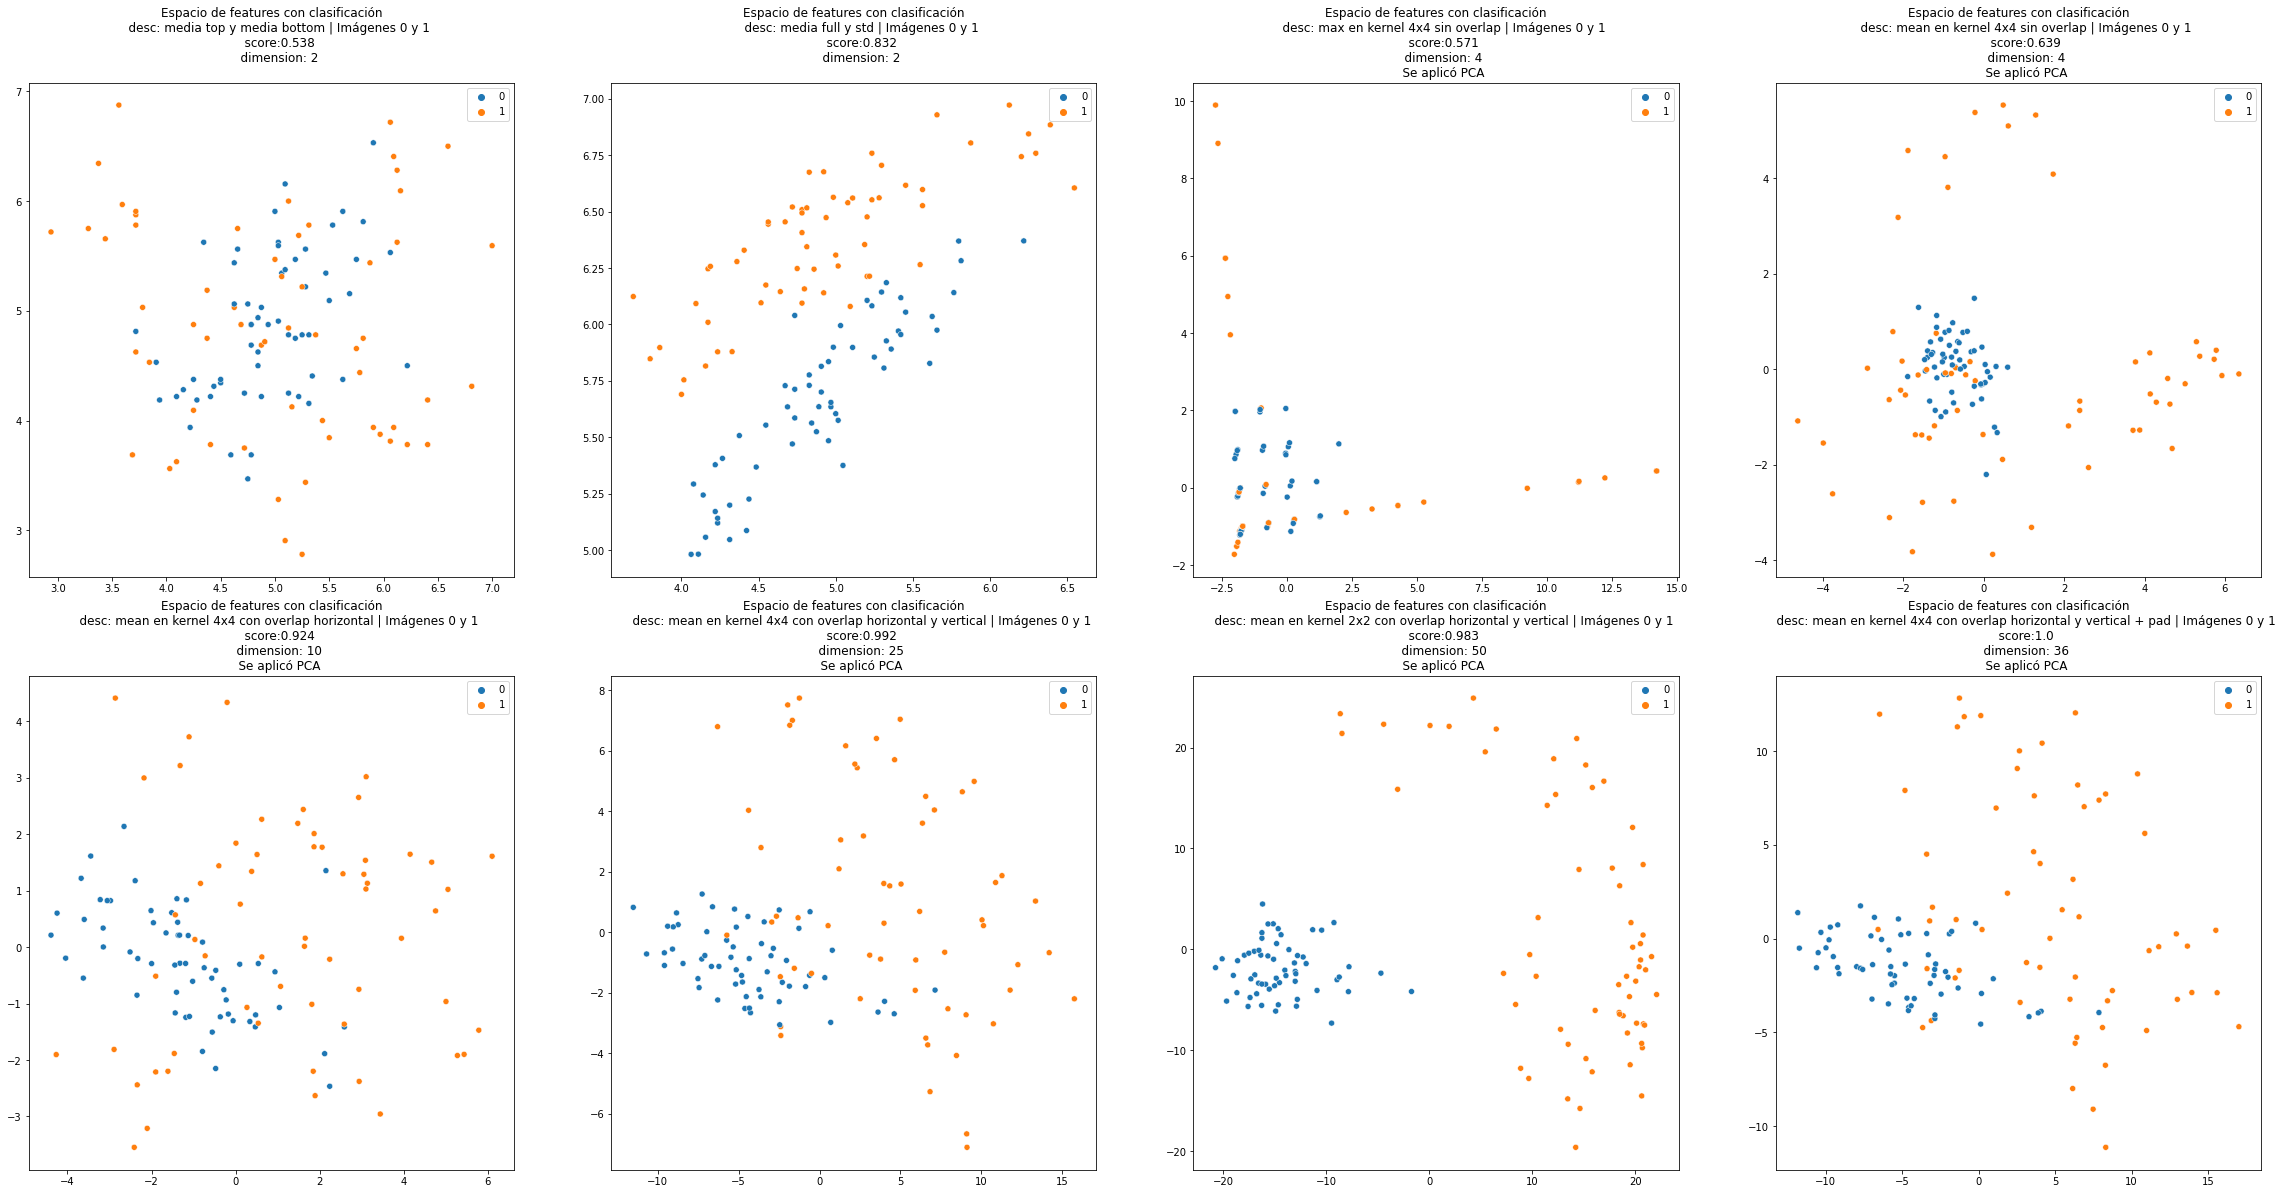

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(40,20))
labA_0_1.plot(axes[0][0])
labB_0_1.plot(axes[0][1])
labC_0_1.plot(axes[0][2])
labD_0_1.plot(axes[0][3])
labE_0_1.plot(axes[1][0])
labF_0_1.plot(axes[1][1])
labG_0_1.plot(axes[1][2])
labH_0_1.plot(axes[1][3])

Nota: si bien entendemos que el perceptrón simple genera una frontera lineal para clasificar las observaciones, en los casos en los que aplicamos técnicas de reducción de la dimensionalidad no vamos a observar una separación lineal.

Dígitos 0 a 10

> Aplicando PCA...
> Aplicando PCA...
> Aplicando PCA...
> Aplicando PCA...
> Aplicando PCA...
> Aplicando PCA...


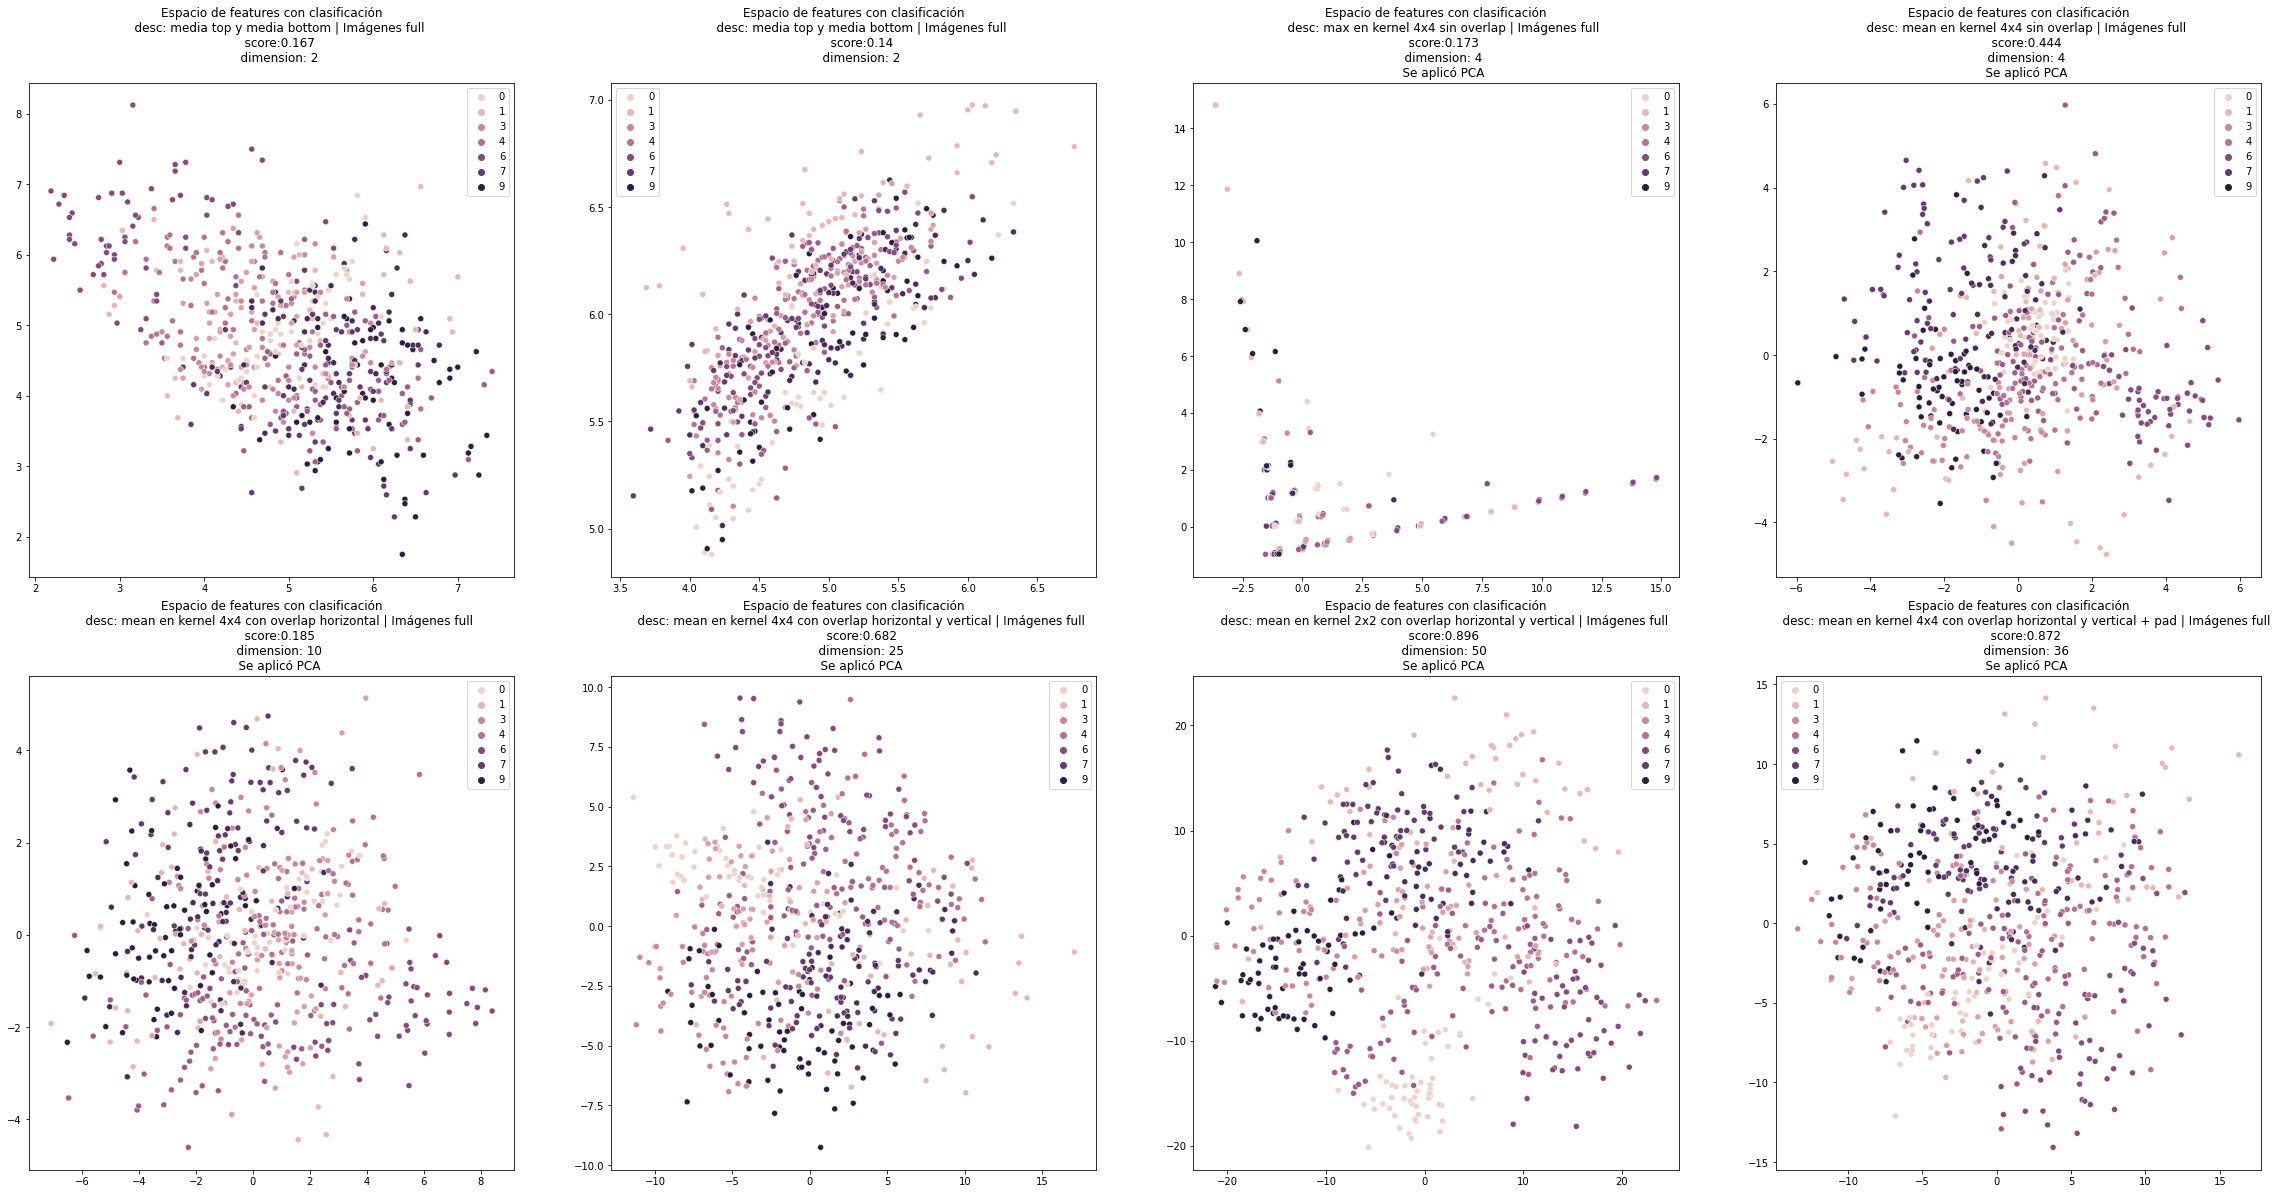

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(40,20))
labA_full.plot2(axes[0][0])
labB_full.plot2(axes[0][1])
labC_full.plot2(axes[0][2])
labD_full.plot2(axes[0][3])
labE_full.plot2(axes[1][0])
labF_full.plot2(axes[1][1])
labG_full.plot2(axes[1][2])
labH_full.plot2(axes[1][3])



**Ejercicio 2)**

- En el caso binario, el acurracy estaria muy cerca del 50%.
- En el caso de multiclase con 10 digitos, rondaria el 10%.

A continuación, corremos un ejemplo de cada caso para comprobación:

In [ ]:
import pandas as pd

X_bin_train_bal, X_bin_test_bal, y_bin_train_bal, y_bin_test_bal = train_test_split(X_bin, y_bin, test_size=0.33, random_state=42, stratify = y_bin)

pd.Series(y_bin_test).value_counts()
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

dmc = DummyClassifier(strategy = "uniform").fit(X_bin_train_bal, y_bin_train_bal)

accuracy_score(y_bin_test_bal ,dmc.predict(X_bin_test_bal))

0.4789915966386555

In [ ]:
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X, y, test_size=0.33, random_state=42, stratify = y)
dmc_2 = DummyClassifier(strategy = "uniform").fit(X_train_bal, y_train_bal)

accuracy_score(y_test_bal ,dmc.predict(X_test_bal))

0.10437710437710437

**Ejercicio 3)**

Caso binario
- Accuracy dummy: 0.4957983193277311
- Estrategia A: accuracy 0.538
- Estrategia B: accuracy 0.832
- Estrategia C: accuracy 0.571
- Estrategia D: accuracy 0.639
- Estrategia E: accuracy 0.924
- Estrategia F: accuracy 0.992
- Estrategia G: accuracy 0.983
- Estrategia H: accuracy 1.0

Caso complejo
- Accuracy dummy: 0.10101010101010101
- Estrategia A: accuracy 0.167
- Estrategia B: accuracy 0.14
- Estrategia C: accuracy 0.173
- Estrategia D: accuracy 0.444
- Estrategia E: accuracy 0.185
- Estrategia F: accuracy 0.682
- Estrategia G: accuracy 0.896
- Estrategia H: accuracy 0.872

Si bien hay resultados bastante próximos en algunos casos, los perceptrones simples entrenados con las estrategias mencionadas superan al clasificador aleatorio ensayado, tanto en el caso binario como en el complejo.